# Hands-on session on Quantum reservoir computing

During this lecture we are going to use the library "benchmarking_qrc" to learn about quantum reservoir computing. But, we will also use numpy and matplotlib.

The goal of this session is to complete 2 exercises.
1. Plot the echo state property.
2. Train a Quantum reservoir and asses th linear memory capacity.

In [ ]:
# Run in Google Colab
!pip install -U pip setuptools wheel --quiet
!pip install -U --quiet matplotlib "numpy>=2.0,<2.3" "scipy>=1.13"
!pip install benchmarking-qrc --no-deps --quiet

In [ ]:
# Only for local use
#import os
#import sys

#repo_path = os.path.dirname(os.getcwd())
#package_path = repo_path + "/src"
#sys.path.append(package_path)

In [1]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq

import benchmarking_qrc as qrc
from benchmarking_qrc import run_memory_capacity as mc

def check_solution(solution, exp_solution):
    
    if solution.shape == exp_solution.shape:
        if np.all(solution == exp_solution):
            print("Correct!")
        else:
            print("Try again!")
    else:
        print("Try again!")

c:\Users\danie\Desktop\Daniel\Doctorado\GitLab-Repos\Benchmarking_QRC\.venv\Lib\site-packages\google\protobuf\__init__.py:37: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


### Exercise 0 - Define density matrix and hamiltonian

In this first exercise, we will learn to define a quantum state in the density matrix formalism and construct our first hamiltonian.

To define the initial state you can use `qrc.reservoir.initial_state(num_sites, dim_site)` or `numpy`.

In [2]:
def initial_reservoir(num_sites, dim_site):
    """Density matrix with all states at |0>

    Args:
        num_sites (int): Number of sites in the system
        dim_site (int): Hilbert dimension of each site.
    """
    # Put your code here: Prepare the state |00><00|
    return qrc.reservoir.initial_state(num_sites, dim_site)

In [3]:
num_sites, dim_site = 2, 2
solution = initial_reservoir(num_sites, dim_site)
exp_solution = np.array([[1, 0, 0, 0], [0]*4, [0]*4, [0]*4])

check_solution(solution, exp_solution)

Correct!


Now, we will define the dynamics of a fermionic system following this quadratic hamiltonian 
$$ H = \sum_{i,j=1}^{N}J_{ij}f_{i}^{\dagger}f_{j} $$
and the evolution operator associated to it: $e^{-iH\Delta t}$.

You can define the $J_{ij}$ coefficients with: 
- `qrc.hamiltonian.get_coefficients(num_sites, coef_range=[0, 1], seed=1)`.  

Define a quadratic hamiltonian with:  
- `qrc.hamiltonian.quadratic_op(num_sites, is_bosonic=..., dimensions=..., coefficients=...)`

and build the evolution operator with:
-  `qrc.hamiltonian.get_evolution_op(hamiltonian, dt=...)`


In [4]:
def my_hamiltonian(num_sites, dim_site):
    """Define previous quadratic hamiltonian

    Args:
        num_sites (int): Number of sites in the system.
        dim_site (int): Hilbert dimension of each site.
    """
    # Put your code here: Define J_ij coefficients
    J_ij = qrc.hamiltonian.get_coefficients(num_sites, coef_range=[0, 1], seed=1) 
    
    # Put your code here: Define quadratic hamiltonian
    return qrc.hamiltonian.quadratic_op(num_sites, is_bosonic=False, dimensions=dim_site, coefficients=J_ij)


def evolution_op(hamiltonian, delta_t):
    """Define the evolution operator related to the previous hamiltonian
    and let it evolves for 10 units.

    Args:
        hamiltonian (np.array): Matrix describing system dynamics.
        delta_t (float): Time we let the system evolve.
    """
    # Put your code here: Define evolution operator
    return qrc.hamiltonian.get_evolution_op(hamiltonian, dt=delta_t)
    
    

In [5]:
solution_hamiltonian = my_hamiltonian(2, 2)
solution_evolution = evolution_op(my_hamiltonian(2, 2), 10)


exp_sol_hamiltonian = np.array([
    [0.+0.j]*4, 
    [0.+0.j, 0.72+0.j, 0.+0.j  , 0.+0.j  ], 
    [0.+0.j, 0.+0.j  , 0.42+0.j, 0.+0.j  ], 
    [0.+0.j, 0.+0.j  , 0.+0.j  , 1.14+0.j]
])
exp_sol_evolution = np.array([
   [ 1.+0.j, 0.  +0.j ,  0.  +0.j  ,  0.  +0.j  ], 
   [ 0.+0.j, 0.61-0.8j,  0.  -0.j  ,  0.  +0.j  ],
   [ 0.+0.j, 0.  -0.j , -0.52+0.86j,  0.  +0.j  ],
   [ 0.+0.j, 0.  +0.j ,  0.  +0.j  ,  0.37+0.93j]
])

print("Checking solution hamiltonian...")
check_solution(np.around(solution_hamiltonian.todense(), 2), exp_sol_hamiltonian)
print("Checking evolution operator...")
check_solution(np.around(solution_evolution, 2), exp_sol_evolution)


Checking solution hamiltonian...
Correct!
Checking evolution operator...
Correct!


### Exercise 1 - Define QRC dynamics and Echo State Property


<ins>**QRC dynamics** </ins>

The quantum reservoir computing (QRC) dynamics is defined by an erase and write map (see [paper](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202200100) for more information) that can be divide in the following 3 steps:

- Encoding classical data into a quantum state $\Longrightarrow \lvert \psi_k^{(e)} \rangle$.
    - qrc.reservoir.get_input_state(signal, dim, exc_state)
    - $ \lvert \psi_k^{(e=1)} \rangle = \sqrt{s_k}\lvert 0 \rangle + \sqrt{1-s_k}\lvert 1 \rangle$
- Injecting the quantum state into the reservoir $\Longrightarrow \rho(k)$.
    - qrc.reservoir.insert_input(input_state, initial_reservoir)
    - $ \rho(k\Delta t)= \rho_{1, k}^{(e)} \otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} $
- Evolving the reservoir $\Longrightarrow  \rho(k\Delta t)$.
    - qrc.reservoir.evolve(reservoir, evo_op)
    - $ \rho\left(k\Delta t\right)=e^{-iH\Delta t}\left[\rho_{1,k}^{(e)}\otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} \right]e^{iH\Delta t} $

So, let's start building these 3 functions:


In [6]:
# Use signal=0.25 to test your solution
def get_input_state(signal, dim_site, exc_state=1):
    """Encode classical data into a superposition state

        |ψ> = √s|0> + √1-s|1>

    Args:
        signal (float): Classical data.
        dim_site (int): Hilbert dimension of each site.
        exc_state (int): Highest superposition state
    """
    # Put your code here: 
    return qrc.reservoir.get_input_state(signal, dim_site, exc_state)


def inject_state(input_state, reservoir):
    """Introduce the input state into the reservoir

    Args:
        input_state (np.array): Classical data in a superposition state.
        reservoir (np.array): Current state of the quantum system

    """
    # Put your code here:
    return qrc.reservoir.insert_input(input_state, reservoir)


def evolve_reservoir(reservoir, evo_op):
    """Evolve the quantum system following the evolution operator.

    Args:
        reservoir (np.array): Current state of the quantum system
        evo_op (np.array): Evolution operator
    """
    # Put your code here:
    return qrc.reservoir.evolve(reservoir, evo_op)

In [7]:
# Use signal = 0.25
sol_input_state = get_input_state(0.25, dim_site=2)

# Inject the previous input and the initial reservoir
sol_inject_state = inject_state(sol_input_state, initial_reservoir(2, 2))

# Evolve the reservoir with the classical data
sol_evolve_reservoir = evolve_reservoir(sol_inject_state, evolution_op(my_hamiltonian(2, 2), 10))


exp_input_state = np.array([[np.sqrt(0.25)], [np.sqrt(1-0.25)]])
exp_inject_state = np.array([
   [ 0.25     , 0.  ,  0.433    ,  0.], 
   [ 0.       , 0.  ,  0.       ,  0.],
   [ 0.433    , 0.  ,  0.75     ,  0.],
   [ 0.       , 0.  ,  0.       ,  0.]
])
exp_evolve_reservoir = np.array([
   [ 0.25 +0.j  , 0.  +0.j ,  -0.22-0.37j,  0.  +0.j], 
   [ 0.   +0.j  , 0.  -0.j,   0.  -0.j   ,   0.  +0.j],
   [ -0.22+0.37j, 0.  -0.j ,  0.75+0.j   ,   0.  +0.j],
   [ 0.   +0.j  , 0.  +0.j ,  0.  +0.j   ,   0.  +0.j]
])

print("Checking solution input state...")
check_solution(sol_input_state, exp_input_state)
print("Checking evolution inject state...")
check_solution(np.around(sol_inject_state, 3), exp_inject_state)
print("Checking evolution evolve reservoir...")
check_solution(np.around(sol_evolve_reservoir, 2), exp_evolve_reservoir)

    

Checking solution input state...
Correct!
Checking evolution inject state...
Correct!
Checking evolution evolve reservoir...
Correct!


These 3 steps can be summarized with the following completly positive trace preserving (CPTP) map:

$$ \rho\left(k\Delta t\right)=e^{-iH\Delta t}\left[\rho_{1,k}^{(e)}\otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} \right]e^{iH\Delta t} $$

Now, you can implement the CPTP map, using the 3 previous functions.

In [8]:
def cptp_map(signals, ini_reservoir, evo_op, dim_site=2, exc_state=1):
    """Generates a new reservoir state after completing the 3-step iteration.
            1. Encode classical data into a quantum state.
            2. Injecting the quantum state into the reservoir.
            3. Evolving the reservoir.

    Args:
        signals (np.array): List of numbers that it is going to be injected into the reservoir.
        ini_reservoir (np.array): Initial state of the reservoir
        evo_op (np.array): Evolution operator.
    """
    new_reservoir = ini_reservoir
    for signal in signals:
        # Put your code here:
        input_state = get_input_state(signal, dim_site, exc_state)
        new_reservoir = inject_state(input_state, new_reservoir)
        new_reservoir = evolve_reservoir(new_reservoir, evo_op)
        yield new_reservoir

In [9]:
# Check solution:
sol_cptp_map = list(cptp_map([0.25], initial_reservoir(2, 2), evolution_op(my_hamiltonian(2, 2), 10)))

exp_sol_cptp = np.array([
   [ 0.25 +0.j  , 0.  +0.j ,  -0.22-0.37j,  0.  +0.j], 
   [ 0.   +0.j  , 0.  -0.j,   0.  -0.j   ,   0.  +0.j],
   [ -0.22+0.37j, 0.  -0.j ,  0.75+0.j   ,   0.  +0.j],
   [ 0.   +0.j  , 0.  +0.j ,  0.  +0.j   ,   0.  +0.j]
])

print("Checking solution cptp map...")
check_solution(np.around(sol_cptp_map[0], 2), exp_sol_cptp)


Checking solution cptp map...
Correct!


<ins>**Echo state property** </ins>

To avoid any possible effect of the initial conditions of the reservoir we always start with the wash out step before training the system. This step consists in injecting a set of inputs until the initial conditions become irrelevant.

So, in this section, you are going to compute how many iterations (wash-out steps) does your system need to wash out the initial conditions.  

_Remember that one iteration consists of the previous 3 steps: (encode, inject, evolve)_

In [10]:
# Auxiliar functions: Don't forget to run this cell
def tensor_product(matrices: list):
    if len(matrices) == 2:
        return np.kron(matrices[0], matrices[1])
    return np.kron(matrices[0], tensor_product(matrices[1:]))


def excited_reservoir(num_sites: int, dim_site: int, exc_sites=list()):
    """By default the reservoir has all sites at |0>, except the sites in 
    exc_sites found at |1>
    """
    state = np.zeros((dim_site, 1))
    state[0, 0] = 1
    ground_state = state

    state = np.zeros((dim_site, 1))
    state[1, 0] = 1
    excited_state = state

    ground_dm = np.outer(ground_state, ground_state)
    excited_dm = np.outer(excited_state, excited_state)

    sites_dm = [ground_dm] * num_sites

    for site_i in exc_sites:
        sites_dm[site_i - 1] = excited_dm

    return tensor_product(sites_dm)


def convergence(rho_a_generator, rho_b_generator):
    distance = list()
    for rho_a, rho_b in zip(rho_a_generator, rho_b_generator):
        rho = rho_a - rho_b
        distance.append(np.linalg.norm(rho, "fro"))
    return np.array(distance)


In the following function we will have two reservoirs with different initials conditions:

$$\rho_a = \lvert 0010\rangle \langle 0010 \lvert $$
$$\rho_b = \lvert 0001\rangle \langle 0001 \lvert $$

Then, we will evolve both reservoirs injecting the same classical data. After each iteration we will measure the Frobenius distance (or Hilbert-Schmidt distance in the quantum literature) between the reservoir states ($\rho_a$ and $\rho_b$). 

$$||A||_{HS} = \sqrt{Tr(A A^{\dagger})} = \sqrt{\sum_{i,j} |a_{i,j}|^2}$$

where $A=\rho_a - \rho_b$.

How many iterations are necessary to erase the initial conditions? 
- You can answer either numerically or visually with the plot

In [11]:
def echo_state_property(signals, num_sites, dim_site, exc_sites_a, exc_sites_b, dt):
    """Compute the number of iterations needed to erase the initial conditions.

    Args:
        signals (np.array): List of numbers that it is going to be injected into the reservoir.
        num_sites (int): Number of sites in the system.
        dim_site (int): Hilbert dimension of each site.
        exc_sites_a (list): Sites excited from |0> to |1> for system A
        exc_sites_b (list): Sites excited from |0> to |1> for system B
        dt (float): Time we let the system evolve
    """
    # Create two initial reservoir: |0010><0010| and |0001><0001|
    rho_a = excited_reservoir(num_sites, dim_site, exc_sites_a)
    rho_b = excited_reservoir(num_sites, dim_site, exc_sites_b)
    
    # Put your code here: Compute evolution operator    
    hamiltonian = my_hamiltonian(num_sites, dim_site)
    evo_op = evolution_op(hamiltonian, dt)
    
    # Put your code here: Evolve the reservoir state
    rho_a_generator = cptp_map(signals, rho_a, evo_op, dim_site=dim_site)
    rho_b_generator = cptp_map(signals, rho_b, evo_op, dim_site=dim_site)
    
    # Measure the Frobenius distance 
    return convergence(rho_a_generator, rho_b_generator)

In [12]:
num_iterations = 1000
rng_signals = np.random.default_rng(seed=1)
signals = rng_signals.uniform(low=0, high=1, size=num_iterations)

num_sites = 4
exc_sites_a, exc_sites_b  = [3], [4]
dt = 10

frobenius_norm = echo_state_property(signals, num_sites, 2, exc_sites_a, exc_sites_b, dt)
exp_solution = np.array([1.41, 1.32, 1.15, 0.97, 0.82, 0.74, 0.69, 0.65, 0.58, 0.53])
print("Checking solution echo state property...")
check_solution(np.around(frobenius_norm[:10], 2), exp_solution)
print()
print("Now, you can plot it and try different parameters")


Checking solution echo state property...
Correct!

Now, you can plot it and try different parameters


Text(0, 0.5, 'Frobenius norm')

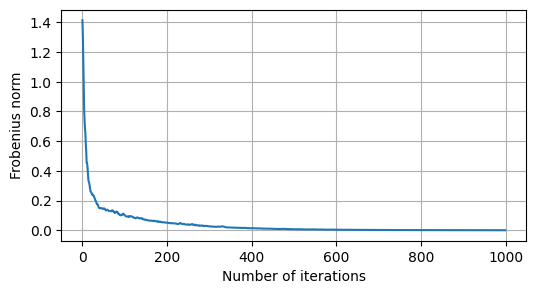

In [13]:
num_iterations = 1000
rng_signals = np.random.default_rng(seed=1)
signals = rng_signals.uniform(low=0, high=1, size=num_iterations)

# You can modify the following parameters and see if the frobenius norm between system A and B changes.
num_sites = 4
exc_sites_a = [3]
exc_sites_b = [4]
dt = 10

frobenius_norm = echo_state_property(signals, num_sites, 2, exc_sites_a, exc_sites_b, dt)
plt.figure(figsize=(6, 3))
plt.plot(frobenius_norm)
plt.xlabel("Number of iterations")
plt.grid()
plt.ylabel("Frobenius norm")


### Exercise 2 -  Train the model and assess the linear memory

You will train a quantum system to recall past inputs and evaluate the performance with the memory capacity.

Our objective is to quantify how well the quantum system can recover past information. So, we will inject a sequence of random inputs ($s_k$) into the reservoir and the system will be trained to match a target function

$$ \hat{y}_k = s_{k-\tau}$$

where $\tau$ is the delay between the input and target.

<div class="alert alert-block alert-info">
    <b>Example:</b>    
    
Given an input sequence:
$$ s = (0.2, 0.3, 0.4, 0.5) $$

The target function after a delay, $\tau=1$ is:

$$ \hat{y} = (0.1, 0.2, 0.3, 0.4) $$

But the reservoir after the training procedure may output a different result:

$$ y = (0.11, 0.19, 0.3, 0.398) $$
</div>

Let us introduce the metric to measure the system memory. The memory capacity is a standard measure of memory in recurrent neural network, defined as:

$$ MC = \frac{Cov^2(y,\hat{y})}{\sigma^2(y)\sigma^2(\hat{y})} $$

where $\sigma(y)$ and $\sigma(\hat{y})$ are the standard deviation of the reservoir and target outputs, respectively.

In [14]:
# Auxiliar functions: Don't forget to run this cell

def get_targets(prev_signal, current_signal, delay):
    if delay == 0:
        target_signal = current_signal
    elif delay > 0:
        target_signal = np.concatenate((prev_signal[-delay:], current_signal[:-delay]))
    
    return target_signal

In [15]:
# Prepare input data
delay = 1
wash_time, train_time, test_time = 10, 10, 10

rng_signals = np.random.default_rng(seed=1)
wash_inputs = rng_signals.uniform(low=0, high=1, size=wash_time)
train_inputs = rng_signals.integers(low=0, high=1, size=train_time, endpoint=True)
test_inputs = rng_signals.integers(low=0, high=1, size=test_time, endpoint=True)

Now, your objective is to prepare the dataset. For that we will follow these steps:
1. A wash-out reservoir.
2. Generate a set of reservoir that contain the classical.
3. Extract information by measuring a set of observables.  
    3.1 Build a set of observables. You can use `qrc.measurements.observables(particle_type, num_sites, dim_site, observable_set)`
    - In the case we are using particle_type="fermion"
    - Observable set is $a^\dagger_i a_j +h.c.$, so observable_set="ij".
4. Collect all of this information in a dataset.
    - If you have all reservoirs and all observables you can generate the dataset with `dataset, _ = qrc.measurements.get_features(reservoirs, all_obs)`

The dataset is of the form: 
$$X=\begin{bmatrix} {\rm Tr}\left[O_{1}\rho\left(u_1\Delta t\right)\right]  & {\rm Tr}\left[O_{2}\rho\left(u_1\Delta t\right)\right] & .. & {\rm Tr}\left[O_{M}\rho\left(u_1\Delta t\right)\right] & 1 \\
{\rm Tr}\left[O_{1}\rho\left(u_2\Delta t\right)\right]  & .. & .. & {\rm Tr}\left[O_{M}\rho\left(u_2\Delta t\right)\right] & 1\\ 
.. & .. & .. & .. & ..\\
{\rm Tr}\left[O_{1}\rho\left(u_L\Delta t\right)\right]  & .. & .. & {\rm Tr}\left[O_{M}\rho\left(u_L\Delta t\right)\right] & 1
\end{bmatrix}$$

and has shape $(L, M+1)$ where L are the number of inputs (or iterations) and M are the number of measurements.

In [16]:
def build_dataset(num_sites, dim_site, dt, signals):
    wash_inputs, train_inputs, test_inputs = signals
    ini_reservoir = initial_reservoir(num_sites, dim_site)
    
    hamiltonian = my_hamiltonian(num_sites, dim_site)
    evo_op = evolution_op(hamiltonian, dt)
    
    # Put your code here: Wash-out reservoir
    wash_reservoir = deque(cptp_map(wash_inputs, ini_reservoir, evo_op, dim_site=dim_site), maxlen=1).pop()
    
    inputs = np.concatenate((train_inputs, test_inputs))
    # Put your code here: Generate a set of reservoir that contain the inputs.
    reservoirs = cptp_map(inputs, wash_reservoir, evo_op, dim_site=dim_site)
    
    # Put your code here: Build a set of observables
    obs = qrc.measurements.observables("fermion", num_sites, dim_site, "ij")
    
    # Put your code here: Build dataset
    dataset, _ = qrc.measurements.get_features(reservoirs, obs)
    
    train_data = dataset[:len(train_inputs), :]
    test_data = dataset[len(train_inputs):, :]
    
    return train_data, test_data

In [17]:
# Defualt parameters: You can change them, once you pass the test.
num_sites = 4
dim_site = 2
dt = 10

signals = (wash_inputs, train_inputs, test_inputs)
train_data, test_data = build_dataset(num_sites, dim_site, dt, signals)
exp_train_data = np.array([
    [0.17, 0.34, 0.12, 0.24, 0.23, 0.04, 0.09, 0.17, 0.41, 0.32, 1.  ],
    [0.1 , 0.25, 0.05, 0.11, 0.21, 0.01, 0.03, 0.16, 0.35, 0.24, 1.  ]]
)
check_solution(np.around(train_data[:2, :], 2), exp_train_data)



Correct!


Finally, to evaluate the performance of the model we need to train the system with the train_data ($X_train$) and train targets ($y_train$). Then, we can find the optimal weights

$$arg\min_{W}|\hat{y}-XW|$$

and evaluate the performance

$$MC=\frac{Cov^2(\hat{y}, y)}{\sigma^2(\hat{y})\sigma^2(y)}.$$

You can also use the optimal weights to make predictions on unseen data.
$$ y_{prediction}=X_{test}w_{opt}.$$


In [18]:
# Auxiliar function: Don't forget to run this cell
def memory_capacity(predictions, targets):
    return (np.corrcoef(predictions, targets)[0, 1]) ** 2

In [19]:
def evaluate_performance(num_sites, dim_site, delay, dt, wash_time, train_time, test_time, seed=1):
    # Prepare input data
    rng_signals = np.random.default_rng(seed=seed)
    wash_inputs = rng_signals.uniform(low=0, high=1, size=wash_time)
    train_inputs = rng_signals.integers(low=0, high=1, size=train_time, endpoint=True)
    test_inputs = rng_signals.integers(low=0, high=1, size=test_time, endpoint=True)

    # Targets to measure the ability to recall past inputs
    train_targets = get_targets(wash_inputs, train_inputs, delay)
    test_targets = get_targets(train_inputs, test_inputs, delay)
    
    # Generate dataset
    signals = (wash_inputs, train_inputs, test_inputs)
    # Put your code here: Build dataset 
    train_data, test_data = build_dataset(num_sites, dim_site, dt, signals)
    
    # Put your code here: Get optimal weights: Use lstsq from scipy (once you pass the test you can use sklearn and other optimizers)
    opt_weights, _, _, _ = lstsq(train_data, train_targets)
    
    # Put your code here: Get predictions
    train_predictions = np.matmul(train_data, opt_weights)
    test_predictions = np.matmul(test_data, opt_weights)
    
    # Put your code here: Evaluate model memory capacity
    train_mc = memory_capacity(train_predictions, train_targets)
    test_mc = memory_capacity(test_predictions, test_targets)
    
    return train_mc, test_mc


In [20]:
# Parameters
num_sites = 5
dt = 10
wash_time, train_time, test_time = 10, 10, 10
delay = 1

train_mc, test_mc = evaluate_performance(num_sites, 2, delay, dt, wash_time, train_time, test_time, seed=2)
exp_test_mc = 0.97094
if np.around(test_mc, 5) == exp_test_mc:
    print("Correct!")
else:
    print("Try again")

Correct!


In [21]:
# Parameters
num_sites = 5
dt = 10

# Put your code here: Which wash_time, train_time and test_time seems reasonable to you
wash_time, train_time, test_time = 1000, 1000, 1000

# Put your code here: Make a plot with Performance vs delay
delays = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_mcs, test_mcs = list(), list()
for delay in delays:
    train_mc, test_mc = evaluate_performance(num_sites, 2, delay, dt, wash_time, train_time, test_time, seed=1)
    train_mcs.append(train_mc)
    test_mcs.append(test_mc)

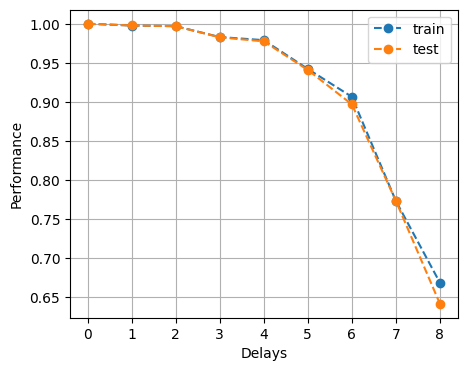

In [22]:
# Plot results

plt.figure(figsize=(5, 4))
plt.plot(delays, train_mcs, "--o", label="train")
plt.plot(delays, test_mcs, "--o", label="test")
plt.grid()
plt.xlabel("Delays")
plt.ylabel("Performance")
plt.legend()


### Exercise 3 - Define your own model

Build your own reservoir and evaluate performance.

Examples:
 - Ising model
 - Bose-Hubbard
 - Previous hamiltonian with qubits.

Have fun and explore!

_Recall: If you feel stuck, you can check: hamiltonian.py_